## LangGraph State Persistence Example

This notebook demonstrates state persistence and checkpoint management
using LangGraph with an in-memory checkpointer.

The workflow generates:
- A joke based on a topic
- An explanation of the joke

It also demonstrates:
- Thread-based state separation
- Checkpoint history inspection
- State rollback
- Manual state updates


In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [ ]:
llm = ChatGroq(model="openai/gpt-oss-20b")

In [4]:
class JokeState(TypedDict):

    topic: str
    joke: str
    explanation: str

### Node 1: Generate Joke

This node:

1. Reads `topic` from state
2. Sends a prompt to the LLM
3. Returns the generated joke

It updates only the `joke` field in the state.


In [5]:
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {'joke': response}

### Node 2: Generate Explanation

This node:

1. Reads the generated `joke`
2. Sends it to the LLM
3. Returns an explanation

It updates only the `explanation` field in the state.


In [6]:
def generate_explanation(state: JokeState):

    prompt = f'Write an explanation for the joke {state["joke"]}'
    response = llm.invoke(prompt).content

    return {'explanation': response}

### Constructing the Graph

Workflow structure:

START → generate_joke → generate_explanation → END

We compile the graph using an InMemorySaver checkpointer
to enable state persistence.


In [7]:
graph = StateGraph(JokeState)

graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

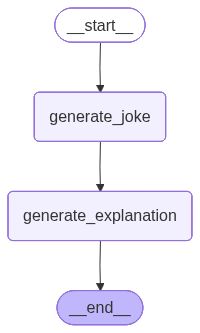

In [9]:
workflow

### Thread-Based State Isolation

Each execution uses a configuration:

```python
config = {"configurable": {"thread_id": "1"}}


In [8]:
config1 = {"configurable": {"thread_id": "1"}}
workflow.invoke({'topic':'pizza'}, config=config1)

{'topic': 'pizza',
 'joke': 'Why did the pizza apply for a job?  \nBecause it wanted to get a *slice* of the action! 🍕',
 'explanation': '**Explanation of the joke**\n\n> **Why did the pizza apply for a job?  \n>  Because it wanted to get a *slice* of the action!** 🍕\n\nThe joke is a classic example of a **pun** – a play on words that relies on a double meaning.\n\n1. **The absurd premise**  \n   - A pizza is a food, not a person, so the idea that it would “apply for a job” is already ridiculous. The humor starts with this absurd anthropomorphism: the pizza is treated like a human who can think, decide, and apply for employment.\n\n2. **The double meaning of “slice”**  \n   - **Literal meaning**: In pizza‑talk, a “slice” is a wedge‑shaped portion of the whole pie.  \n   - **Figurative meaning**: In everyday speech, to “get a slice of the action” means to get a part of something exciting or important – a piece of the activity or a chance to be involved.\n\n3. **The word “action”**  \n  

In [9]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza apply for a job?  \nBecause it wanted to get a *slice* of the action! 🍕', 'explanation': '**Explanation of the joke**\n\n> **Why did the pizza apply for a job?  \n>  Because it wanted to get a *slice* of the action!** 🍕\n\nThe joke is a classic example of a **pun** – a play on words that relies on a double meaning.\n\n1. **The absurd premise**  \n   - A pizza is a food, not a person, so the idea that it would “apply for a job” is already ridiculous. The humor starts with this absurd anthropomorphism: the pizza is treated like a human who can think, decide, and apply for employment.\n\n2. **The double meaning of “slice”**  \n   - **Literal meaning**: In pizza‑talk, a “slice” is a wedge‑shaped portion of the whole pie.  \n   - **Figurative meaning**: In everyday speech, to “get a slice of the action” means to get a part of something exciting or important – a piece of the activity or a chance to be involved.\n\n3. **The wo

### Viewing State History

`workflow.get_state_history(config)` returns
all checkpoints for the thread.

This allows tracking how the state evolved over time.


In [10]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza apply for a job?  \nBecause it wanted to get a *slice* of the action! 🍕', 'explanation': '**Explanation of the joke**\n\n> **Why did the pizza apply for a job?  \n>  Because it wanted to get a *slice* of the action!** 🍕\n\nThe joke is a classic example of a **pun** – a play on words that relies on a double meaning.\n\n1. **The absurd premise**  \n   - A pizza is a food, not a person, so the idea that it would “apply for a job” is already ridiculous. The humor starts with this absurd anthropomorphism: the pizza is treated like a human who can think, decide, and apply for employment.\n\n2. **The double meaning of “slice”**  \n   - **Literal meaning**: In pizza‑talk, a “slice” is a wedge‑shaped portion of the whole pie.  \n   - **Figurative meaning**: In everyday speech, to “get a slice of the action” means to get a part of something exciting or important – a piece of the activity or a chance to be involved.\n\n3. **The w

In [11]:
config2 = {"configurable": {"thread_id": "2"}}
workflow.invoke({'topic':'pasta'}, config=config2)

{'topic': 'pasta',
 'joke': 'Why did the spaghetti go to therapy?  \nBecause it kept feeling *torn* between being a noodle and a *pasta*‑tive‑person!',
 'explanation': '**Explanation of the joke**\n\nThe humor comes from a double‑layered pun that mixes literal and figurative meanings:\n\n1. **“Torn”** – In everyday speech, someone who is “torn” feels conflicted or pulled in two directions. The joke also hints at the literal image of spaghetti being physically torn or pulled apart, which is a common visual when you’re eating or cooking it.\n\n2. **“Noodle” vs. “pasta‑tive”** – “Noodle” is a generic, informal term for any kind of pasta, whereas “pasta‑tive” is a playful twist on the word *positive*. By inserting “pasta‑tive” the joke turns the phrase “positive person” into a pasta‑themed wordplay. The spaghetti feels caught between just being a generic noodle and being a “pasta‑tive” (i.e., a positive, confident person).\n\n3. **Therapy** – Therapy is a place where people work through id

In [12]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti go to therapy?  \nBecause it kept feeling *torn* between being a noodle and a *pasta*‑tive‑person!', 'explanation': '**Explanation of the joke**\n\nThe humor comes from a double‑layered pun that mixes literal and figurative meanings:\n\n1. **“Torn”** – In everyday speech, someone who is “torn” feels conflicted or pulled in two directions. The joke also hints at the literal image of spaghetti being physically torn or pulled apart, which is a common visual when you’re eating or cooking it.\n\n2. **“Noodle” vs. “pasta‑tive”** – “Noodle” is a generic, informal term for any kind of pasta, whereas “pasta‑tive” is a playful twist on the word *positive*. By inserting “pasta‑tive” the joke turns the phrase “positive person” into a pasta‑themed wordplay. The spaghetti feels caught between just being a generic noodle and being a “pasta‑tive” (i.e., a positive, confident person).\n\n3. **Therapy** – Therapy is a place where peo

In [17]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti go to therapy?  \nBecause it kept feeling *torn* between being a noodle and a *pasta*‑tive‑person!', 'explanation': '**Explanation of the joke**\n\nThe humor comes from a double‑layered pun that mixes literal and figurative meanings:\n\n1. **“Torn”** – In everyday speech, someone who is “torn” feels conflicted or pulled in two directions. The joke also hints at the literal image of spaghetti being physically torn or pulled apart, which is a common visual when you’re eating or cooking it.\n\n2. **“Noodle” vs. “pasta‑tive”** – “Noodle” is a generic, informal term for any kind of pasta, whereas “pasta‑tive” is a playful twist on the word *positive*. By inserting “pasta‑tive” the joke turns the phrase “positive person” into a pasta‑themed wordplay. The spaghetti feels caught between just being a generic noodle and being a “pasta‑tive” (i.e., a positive, confident person).\n\n3. **Therapy** – Therapy is a place where pe

## Time Travel

### Loading a Specific Checkpoint

By passing a `checkpoint_id` in the config,
we can retrieve or re-run the workflow
from a specific saved state.

This demonstrates rollback capability.


In [18]:
workflow.get_state({"configurable": {"thread_id": "2", "checkpoint_id": "1f10d71c-0291-679b-8000-65777975e355"}})

StateSnapshot(values={'topic': 'pasta'}, next=('generate_joke',), config={'configurable': {'thread_id': '2', 'checkpoint_id': '1f10d71c-0291-679b-8000-65777975e355'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-02-19T09:02:43.157976+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f10d71c-028e-6789-bfff-57b91a4edb1d'}}, tasks=(PregelTask(id='98f25971-2471-cd90-1492-de929dbadbdc', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': 'Why did the spaghetti go to therapy?  \nBecause it kept feeling *torn* between being a noodle and a *pasta*‑tive‑person!'}),), interrupts=())

In [19]:
workflow.invoke(None, {"configurable": {"thread_id": "2", "checkpoint_id": "1f10d71c-0291-679b-8000-65777975e355"}})

{'topic': 'pasta',
 'joke': 'Why did the spaghetti go to therapy?  \n\nBecause it was tired of being *twisted* into knots!',
 'explanation': '**Why the joke works – a quick breakdown**\n\n> **“Why did the spaghetti go to therapy? Because it was tired of being twisted into knots!”**\n\n1. **Anthropomorphism**  \n   The joke starts by treating a noodle as if it were a person who can feel emotions and seek help. That alone sets up a playful, absurd scenario that invites a laugh.\n\n2. **Double meaning of “tired”**  \n   *Tired* can mean **physically exhausted** or **fed up / frustrated**.  \n   - In the literal sense, long‑running spaghetti can become literally “tired” (soft, soggy).  \n   - In the figurative sense, the noodle is **tired of** being in a bad situation. The humor comes from the two interpretations clashing.\n\n3. **Wordplay on “twisted into knots”**  \n   - **Physical twist:** When you cook spaghetti, you can literally twist it into tight, knot‑like shapes.  \n   - **Emotio

In [20]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'pasta', 'joke': 'Why did the spaghetti go to therapy?  \n\nBecause it was tired of being *twisted* into knots!', 'explanation': '**Why the joke works – a quick breakdown**\n\n> **“Why did the spaghetti go to therapy? Because it was tired of being twisted into knots!”**\n\n1. **Anthropomorphism**  \n   The joke starts by treating a noodle as if it were a person who can feel emotions and seek help. That alone sets up a playful, absurd scenario that invites a laugh.\n\n2. **Double meaning of “tired”**  \n   *Tired* can mean **physically exhausted** or **fed up / frustrated**.  \n   - In the literal sense, long‑running spaghetti can become literally “tired” (soft, soggy).  \n   - In the figurative sense, the noodle is **tired of** being in a bad situation. The humor comes from the two interpretations clashing.\n\n3. **Wordplay on “twisted into knots”**  \n   - **Physical twist:** When you cook spaghetti, you can literally twist it into tight, knot‑like shap

### Updating State

### Updating State at a Checkpoint

`workflow.update_state()` allows modifying
state at a specific checkpoint.

This enables:
- Editing inputs
- Replaying execution
- Experimenting with state changes


In [22]:
workflow.update_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f10d71b-1103-62db-8000-9a25ddc396bb", "checkpoint_ns": ""}}, {'topic':'samosa'})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10d74e-0a37-69b2-8001-7ec0efacdb26'}}

In [23]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'samosa'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10d74e-0a37-69b2-8001-7ec0efacdb26'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2026-02-19T09:25:06.137309+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f10d71b-1103-62db-8000-9a25ddc396bb'}}, tasks=(PregelTask(id='f7b174f6-e0cc-49d0-080f-dbc474f7f8a0', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza apply for a job?  \nBecause it wanted to get a *slice* of the action! 🍕', 'explanation': '**Explanation of the joke**\n\n> **Why did the pizza apply for a job?  \n>  Because it wanted to get a *slice* of the action!** 🍕\n\nThe joke is a classic example of a **pun** – a play on words that relies on a double mean

### Re-Executing from a Checkpoint

After selecting a checkpoint,
we can invoke the workflow again.

This resumes execution from that saved state,
preserving persistence behavior.


In [24]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f10d74e-0a37-69b2-8001-7ec0efacdb26"}})

{'topic': 'samosa',
 'joke': 'Why did the samosa go to therapy?\u202fBecause it had too many layers of issues!',
 'explanation': '**Why the joke works – a quick breakdown**\n\n| Element | What it is | Why it’s funny |\n|---------|------------|----------------|\n| **Setup (“Why did the samosa go to therapy?”)** | A classic “why‑does‑X‑go‑to‑Y” question that promises a punchline. | It primes the listener for a twist: we’re about to hear a reason that’s not literal. |\n| **Samosa** | A popular South‑Asian fried pastry made of multiple layers of dough and filling. | The food is a familiar, harmless object that the audience can picture. |\n| **Therapy** | A professional counseling or psychiatric service for dealing with emotional or mental problems. | It’s a serious, human‑centered context that feels unrelated to a snack. |\n| **Punchline (“Because it had too many layers of issues!”)** | A play on two meanings of “layers” and “issues.” | 1. *Literal:* a samosa literally has layers of dough 

In [25]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'samosa', 'joke': 'Why did the samosa go to therapy?\u202fBecause it had too many layers of issues!', 'explanation': '**Why the joke works – a quick breakdown**\n\n| Element | What it is | Why it’s funny |\n|---------|------------|----------------|\n| **Setup (“Why did the samosa go to therapy?”)** | A classic “why‑does‑X‑go‑to‑Y” question that promises a punchline. | It primes the listener for a twist: we’re about to hear a reason that’s not literal. |\n| **Samosa** | A popular South‑Asian fried pastry made of multiple layers of dough and filling. | The food is a familiar, harmless object that the audience can picture. |\n| **Therapy** | A professional counseling or psychiatric service for dealing with emotional or mental problems. | It’s a serious, human‑centered context that feels unrelated to a snack. |\n| **Punchline (“Because it had too many layers of issues!”)** | A play on two meanings of “layers” and “issues.” | 1. *Literal:* a samosa literally 